In [ ]:
import time
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from lxml import html
from scholarly import scholarly
import json

In [ ]:
#Terms of Service issue: For many website, even they are public most of time it is forbidden to scrape so many data in short period of time, which is also Computer Fraud and Abuse Act (CFAA)
#To mitigate this issue I would use timer to escape from rate limit and not disturb server a lot.

#For Representativeness and Selection Bias issue: Especailly screaping social media data might be problematic in terms of Representativeness and Selection Bias since most of time we scrape specific period of time.
#To mitigate this issue, if there is available meta data I can compare scraped data demography with the possible expected distribution.

In [11]:
faculty_list = [
    {"name": "Matt Golder", "url": "https://polisci.la.psu.edu/people/mrg19/", "scholar_id": "yPbxmSwAAAAJ"},
    {"name": "Sona N. Golder", "url": "https://polisci.la.psu.edu/people/sng11/", "scholar_id": "Cuz1fTcAAAAJ"},
    {"name": "Lee Ann Banaszak", "url": "https://polisci.la.psu.edu/people/lab14/", "scholar_id": "i_LM_yAAAAAJ"},
    {"name": "Bruce Desmarais", "url": "https://polisci.la.psu.edu/people/bbd5087/", "scholar_id": "fRM8IN4AAAAJ"},
    {"name": "Joseph Wright", "url": "https://polisci.la.psu.edu/people/jgw12/", "scholar_id": "DV5ECYgAAAAJ"},
    {"name": "Jared Edgerton", "url": "https://polisci.la.psu.edu/people/jared-edgerton/", "scholar_id": "LLcIlUkAAAAJ"},
    {"name": "Daniel Tavana", "url": "https://polisci.la.psu.edu/people/daniel-tavana/", "scholar_id": "j2a1_doAAAAJ"},
    {"name": "Michael Nelson", "url": "https://polisci.la.psu.edu/people/mjn15/", "scholar_id": "SrGrUPsAAAAJ"},
    {"name": "Bumba Mukherjee", "url": "https://polisci.la.psu.edu/people/sxm73/", "scholar_id": "6sS40fEAAAAJ"},
    {"name": "Jim Piazza", "url": "https://polisci.la.psu.edu/people/jap45/", "scholar_id": "0hfBRfkAAAAJ"}
]
scraped_profiles = []
all_citation_history = []
scholar_metrics = []

In [12]:
for person in faculty_list:
    name = person["name"]
    url = person["url"]
    sid = person["scholar_id"]
    resp = requests.get(url)
    tree = html.fromstring(resp.content)
    interest_nodes = tree.xpath(
        "//h2[normalize-space()='Areas of Interest']/following-sibling::ul[1]/li"
        " | //h2[normalize-space()='Research Interests']/following-sibling::ul[1]/li")
    interests_list = [n.text_content().strip() for n in interest_nodes]
    interests_str = "; ".join(interests_list)
    scraped_profiles.append({
        "name": name,
        "interests": interests_str})
    profile = scholarly.fill(scholarly.search_author_id(sid))
    cites_per_year = profile.get("cites_per_year", {})
    temp_df = pd.DataFrame({
        "year": list(cites_per_year.keys()), 
        "cites": list(cites_per_year.values())
    })
    temp_df["name"] = name
    all_citation_history.append(temp_df)
    scholar_metrics.append({
        "name": name,
        "total_citations": profile.get("citedby", 0),
        "h_index": profile.get("hindex", 0)
    })
    time.sleep(1)

In [14]:
citation_df = pd.concat(all_citation_history, ignore_index=True)
citation_df["year"] = citation_df["year"].astype(int)

In [54]:
with open("scraped_profiles.json", "w", encoding="utf-8") as f:
    json.dump(scraped_profiles, f, indent=4)

citation_df.to_json("citation.json", orient="records", indent=4)

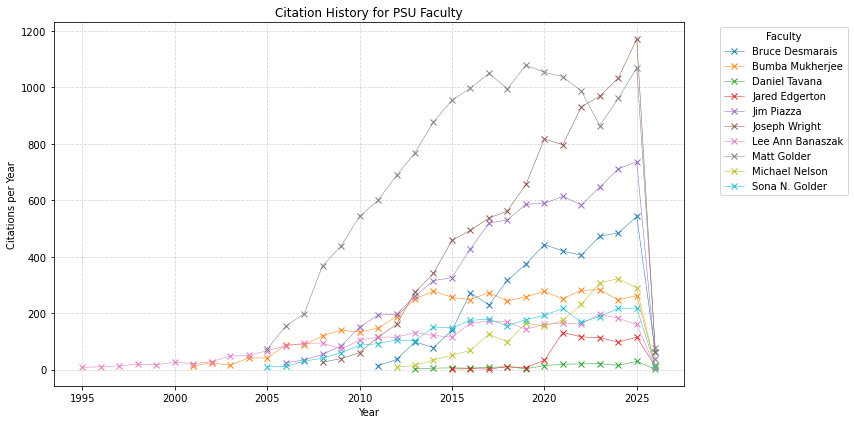

In [28]:
#Q3

pivot_df = citation_df.pivot(index="year", columns="name", values="cites")
plt.figure(figsize=(12, 6))
pivot_df.plot(kind='line', marker='x', linewidth=0.5, ax=plt.gca())
plt.title("Citation History for PSU Faculty")
plt.ylabel("Citations per Year")
plt.xlabel("Year")
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Faculty", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.savefig('Figure1.png')
plt.show()

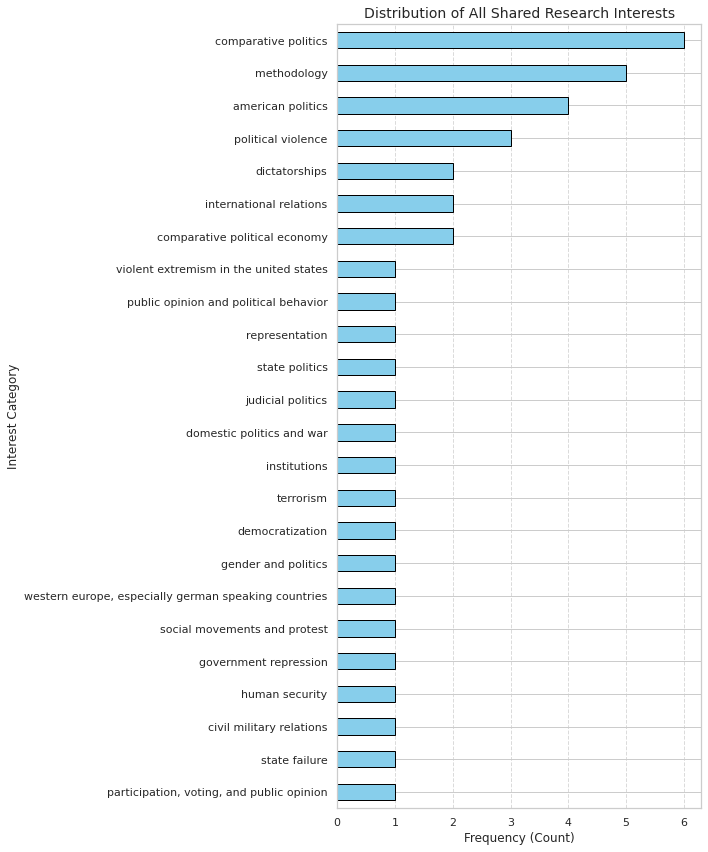

In [42]:
all_interests = []
for p in scraped_profiles:
    split_interests = [i.strip().lower() for i in p["interests"].split(';')]
    all_interests.extend(split_interests)
kw_counts = pd.Series(all_interests).value_counts()

all_interests = []
for p in scraped_profiles:
    split_interests = [i.strip().lower() for i in p["interests"].split(';')]
    all_interests.extend(split_interests)
kw_counts = pd.Series(all_interests).value_counts()
plt.figure(figsize=(10, 12)) 
kw_counts.sort_values(ascending=True).plot(kind='barh', color='skyblue', edgecolor='black')
plt.title('Distribution of All Shared Research Interests', fontsize=14)
plt.xlabel('Frequency (Count)', fontsize=12)
plt.ylabel('Interest Category', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('Figure2.png')
plt.show()

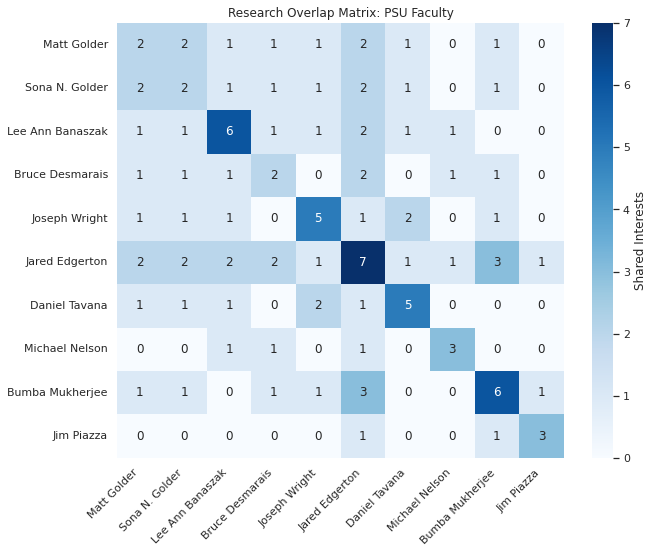

In [ ]:
faculty_interests = {p['name']: set([i.strip().lower() for i in p['interests'].split(';')]) 
                    for p in scraped_profiles}

names = list(faculty_interests.keys())
matrix_data = []
for name1 in names:
    row = []
    for name2 in names:
        shared = len(faculty_interests[name1].intersection(faculty_interests[name2]))
        row.append(shared)
    matrix_data.append(row)

overlap_df = pd.DataFrame(matrix_data, index=names, columns=names)

plt.figure(figsize=(10, 8))
sns.heatmap(overlap_df, annot=True, cmap="Blues", cbar_kws={'label': 'Shared Interests'})
plt.title('Research Overlap Matrix: PSU Faculty')
plt.xticks(rotation=45, ha='right')
plt.savefig('Figure3.png')
plt.show()

In [ ]:
# Matt Golder and Sona N. Golder show a perfect overlap in Comparative Politics and Methodology, suggesting a highly unified research agenda.
# Bumba Mukherjee  and Jared Edgerton share the highest number of cross-field interests (3), including International Relations; Methodology; Political Violence
# Methodology is the most common interest across faculty.

In [51]:
#Q5

median_cites = citation_df.groupby("name")["cites"].median().sort_values(ascending=False)
print(median_cites.to_string())

# I calculated median using only observed years, where the scholar had at least one citation. 
#I chose this approach because the dataset is restricted to a scholar's active period. 
# I thought that treating years prior to their first publication or years with zero citations as zeros would introduce noise.


name
Matt Golder         871.5
Joseph Wright       494.0
Jim Piazza          326.0
Bruce Desmarais     294.0
Bumba Mukherjee     215.5
Sona N. Golder      149.0
Michael Nelson      126.0
Lee Ann Banaszak     99.0
Jared Edgerton       22.5
Daniel Tavana         9.0
